In [1]:
import sys
# Assuming we are in the notebook directory add this so that we can import the library
sys.path.append('..')

import numpy as np
import scipy.stats
import matplotlib
import matplotlib.pyplot as plt

matplotlib.style.use('ggplot')
%matplotlib inline

# Inference with ELFI: the MA(2) model

The 2nd order moving average model, MA(2), is a common model used in univariate time analysis. Assuming zero mean it can be written as

$$
y_t = w_t + \theta_1 w_{t-1} + \theta_2 w_{t-2},
$$

where $\theta_1, \theta_2 \in \mathbb{R}$ and $(w_k)_{k\in \mathbb{Z}} \sim N(0,1)$ represents an independent and identically distributed sequence of white noise.

### The observed data and the inference problem

In this notebook, our task is to infer the parameters $\theta_1, \theta_2$ given a sequence of 100 observations $y$ that originate from an MA(2) process. Let's define this MA(2) simulator as a Python function:

In [2]:
def MA2(t1, t2, n_sim=1, prng=None):
    n_obs = 100
    if prng is None:
        prng = np.random.RandomState()
    w = prng.randn(n_sim, n_obs+2) # i.i.d. sequence ~ N(0,1)
    y = w[:,2:] + t1 * w[:,1:-1] + t2 * w[:,:-2]
    return y

In ELFI, all non-constant data is in at least 2-dimensional NumPy arrays with different observations on the 0-axis. **Important**: in order to guarantee a consistent state of pseudo-random number generation, the simulator must have `prng` as a keyword argument for reading in a `numpy.RandomState` object. Additionally, a simulator that supports vectorized operations should accept the keyword argument `n_sim` that defines how many sequences should be returned.

Let's now use this simulator to create the observations with true parameter values $\theta_1=0.6, \theta_2=0.2$ (from now on these are considered unknown):

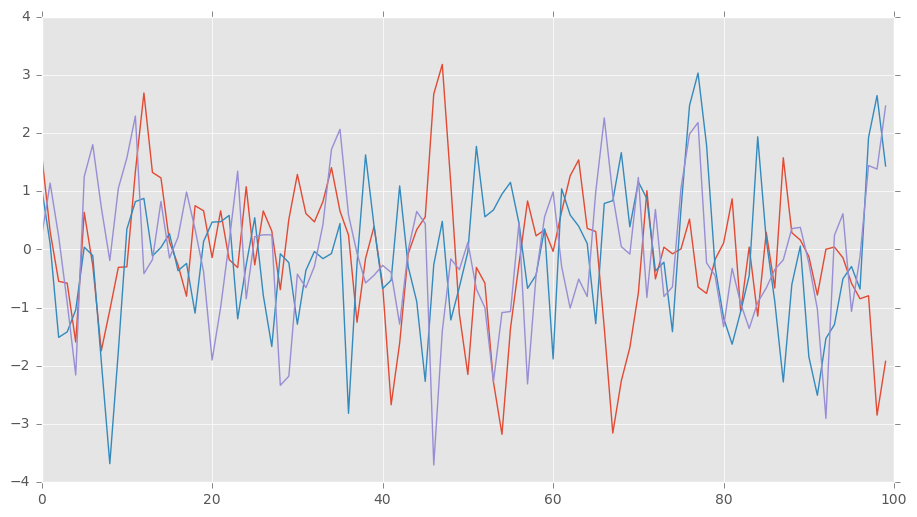

In [3]:
# true parameters
t1_0 = 0.6
t2_0 = 0.2

# Set up observed data y
y = MA2(t1_0, t2_0)

# Plot the observed sequence
plt.figure(figsize=(11, 6));
plt.plot(y.flatten());

# To illustrate the stochasticity, let's plot a couple of more observations with the same true parameters:
plt.plot(MA2(t1_0, t2_0).flatten());
plt.plot(MA2(t1_0, t2_0).flatten());

### Approximate Bayesian Computation

The figure above illustrates the difficulty of inferring $\theta_1, \theta_2$. One way to approach this kind of problems is Approximate Bayesian Computation (ABC), which is based on the intuition that similar data is likely to have been produced by similar parameters. Although the idea may appear inapplicable for the task at hand, it works when a large number of samples can be used. For more information about ABC, please see e.g. 

* [Marin, J.-M., Pudlo, P., Robert, C. P., and Ryder, R. J. (2012). Approximate Bayesian computational
methods. *Statistics and Computing*, 22(6):1167–1180.](http://link.springer.com/article/10.1007/s11222-011-9288-2)
* [Lintusaari, J., Gutmann, M. U., Dutta, R., Kaski, S., and Corander, J. (2016). Fundamentals and recent
developments in approximate Bayesian computation. *Systematic Biology*, doi: 10.1093/sysbio/syw077.](http://sysbio.oxfordjournals.org/content/early/2016/09/07/sysbio.syw077.full.pdf)
* https://en.wikipedia.org/wiki/Approximate_Bayesian_computation

### Defining the inference problem in ELFI

In ELFI, the inference problem is described in the form of a directed acyclic graph ([DAG](https://en.wikipedia.org/wiki/Directed_acyclic_graph)), which associates each node with its parent nodes. This provides an intuitive means to describe complex dependencies that are automatically fulfilled by the inference engine. So let's build such a model.

As is usual in Bayesian statistical inference, we need to define *prior* distributions for the unknown parameters $\theta_1, \theta_2$. In ELFI the priors can be any of the continuous and discrete distributions available in `scipy.stats` (for custom priors, see [below](#custom_prior)). For simplicity, let's start by assuming that both parameters follow `Uniform(0, 2)`.

In [4]:
import elfi

# a node is defined by giving it a name, a distribution from scipy.stats and its parents (here constants 0 and 2)
t1 = elfi.Prior('t1', scipy.stats.uniform, 0, 2)

# ELFI also supports giving the scipy.stats distributions as strings
t2 = elfi.Prior('t2', 'uniform', 0, 2)

Next, we define the *Simulator* node by giving it the `MA2` function, and the priors as its parents. As this node can be compared with observations, we give them as well.

In [5]:
Y = elfi.Simulator('MA2', MA2, t1, t2, observed=y)

But how does one compare the simulations with the observed sequence? As was evident from the plot of just a few observed sequences, a direct pointwise comparison is unproductive. Indeed, the comparison of simulated sequences is often the most difficult (and arbitrary) part of ABC. Typically one chooses one or more *ad hoc* summary statistics and then calculates the discrepancy between those.

Here, we will apply the intuition arising from the definition of the MA(2) process, and use the autocovariances with lags 1 and 2 as the summary statistics, and evaluate the discrepancy with the common Euclidean L2-distance.

In [6]:
def autocov(x, lag=1):
    mu = np.mean(x, axis=1, keepdims=True)
    var = np.var(x, axis=1, keepdims=True, ddof=1)
    C = np.mean(x[:,lag:] * x[:,:-lag], axis=1, keepdims=True) - mu**2
    tau = C / var
    return tau

def distance(x, y):
    d = np.linalg.norm( np.array(x) - np.array(y), ord=2, axis=0)
    return d

As is familiar by now, a `Summary` node is defined by giving the autocovariance function and the simulated data (which includes the observed as well):

In [7]:
S1 = elfi.Summary('S1', autocov, Y)

The node syntax requires a function, so defining the second summary statistic as autocovariance with lag 2 is a bit more involved. Instead a writing a complete function from scratch, we can create a *closure* that fixes the keyword argument `lag`:

In [8]:
from functools import partial

# this is a more efficient way to say `lambda x: autocov(x, lag=2)`
autocov2 = partial(autocov, lag=2)

S2 = elfi.Summary('S2', autocov2, Y)

# Finish the model with the final node that calculates the squared distance (S1_sim-S1_obs)**2 + (S2_sim-S2_obs)**2
d = elfi.Discrepancy('d', distance, S1, S2)

Now that the inference model is defined, ELFI can visualize the DAG:

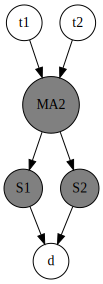

In [9]:
elfi.draw_model(d)

<a id='custom_prior'></a>


### Defining custom priors

Although the above definition is perfectly valid, having both prior distributions as `Uniform(0,2)` is bad, as the case becomes unidentifiable (i.e. the solution is not unique). To avoid this, *Marin et al. (2012)* defined the priors such that $-2<\theta_1<2$ with $\theta_1+\theta_2>-1$ and $\theta_1-\theta_2<1$ i.e. the parameters are sampled from a triangle (see below).

In ELFI, custom distributions can be defined as **static** classes (i.e. they only have static methods) that behave in a way similar to distributions from scipy.stats. In this case we only need these for sampling, so implementing the static `rvs` method suffices. As was in the context of simulators, it is important to accept the keyword argument `random_state`, which is needed for ELFI's internal book-keeping of pseudo-random number generation.

In [10]:
# define prior for t1 as in Marin et al., 2012 with t1 in range [-b, b]
class MarinPrior_t1():
    def rvs(b, size=1, random_state=None):
        u = scipy.stats.uniform.rvs(loc=0, scale=1, size=size, random_state=random_state)
        t1 = np.where(u<0.5, np.sqrt(2.*u)*b-b, -np.sqrt(2.*(1.-u))*b+b)
        return t1

# define prior for t2 conditionally on t1 as in Marin et al., 2012, in range [-a, a]
class MarinPrior_t2():
    def rvs(t1, a, size=1, random_state=None):
        locs = np.maximum(-a-t1, t1-a)
        scales = a - locs
        t2 = scipy.stats.uniform.rvs(loc=locs, scale=scales, size=size, random_state=random_state)
        return t2

These indeed sample from a triangle:

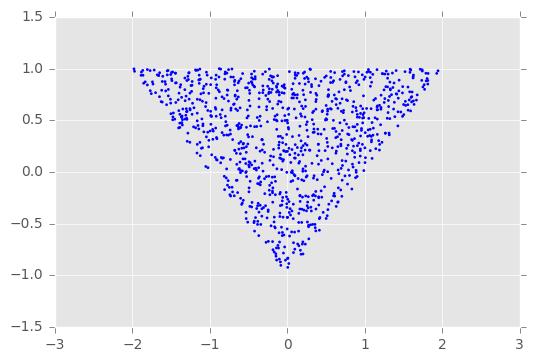

In [11]:
t1_1000 = MarinPrior_t1.rvs(2, 1000)
t2_1000 = MarinPrior_t2.rvs(t1_1000, 1, 1000)
plt.scatter(t1_1000, t2_1000, s=4, edgecolor='none');

Let's change the earlier priors to the new ones in the inference model:

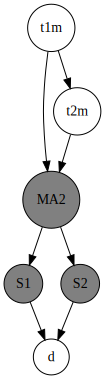

In [12]:
# define new priors
t1m = elfi.Prior('t1m', MarinPrior_t1, 2)
t2m = elfi.Prior('t2m', MarinPrior_t2, t1, 1)

# change these in place of the earlier nodes, keeping the old children
t1 = t1.change_to(t1m, transfer_parents=False, transfer_children=True)
t2 = t2.change_to(t2m, transfer_parents=False, transfer_children=True)

elfi.draw_model(d)

### Basic inference with rejection sampling

The simplest ABC algorithm samples parameters from their prior distributions, runs the simulator with these and compares to the observations. The samples are either accepted or rejected depending on how large the discrepancy is. The accepted samples represent samples from the posterior distribution.

In ELFI, ABC methods are initialized with the discrepancy node and a list of inferred parameters (in Python lists are defined with square brackets). The optional keyword argument `batch_size` is related to parallelization (see the chapter on [parallelization](#parallelization) below).

In [13]:
rej = elfi.Rejection(d, [t1, t2], batch_size=10000)

After the ABC method has been initialized, samples can be drawn from it. By default, rejection sampling in ELFI works in `quantile` mode i.e. a certain quantile of the samples with smallest discrepancies is accepted. The `sample` method requires the number of output samples as a parameter. Note that the simulator is then run `(N/quantile)` times.

The `sample` method returns a dictionary, whose item 'samples' contains a list of the posterior numpy arrays. The dictionary also includes e.g. the item 'threshold', which is the threshold value resulting in the requested quantile.

In [14]:
# Time and run the simulator
N = 1000
%time result_dict = rej.sample(N, quantile=0.01)

# The sample method returns a dictionary with an item `samples` that is a list of posteriors
[t1_post, t2_post] = result_dict['samples']

# print the threshold and posterior means
print("Number of accepted samples {} with threshold {:.2f}".format(len(t1_post), result_dict['threshold']))
print("Posterior means: {:.2f} {:.2f}".format(t1_post.mean(), t2_post.mean()))

elfi.methods - INFO - Rejection: Running with 100000 proposals.


CPU times: user 1.05 s, sys: 256 ms, total: 1.3 s
Wall time: 552 ms
Number of accepted samples 1000 with threshold 0.05
Posterior means: 0.73 0.41


Rejection sampling can also be performed `threshold` based i.e. accepting all samples that result in a discrepancy below certain threshold. Note that since we require a fixed number of samples, there is no guarantee how many times the simulator will be run.

In [15]:
%time result_dict2 = rej.sample(N, threshold=0.1)
[t1_post2, t2_post2] = result_dict2['samples']
print("Posterior means: {:.2f} {:.2f}".format(t1_post2.mean(), t2_post2.mean()))

elfi.methods - INFO - Rejection: Running with 1000 proposals.
elfi.methods - INFO - Rejection: Running with 21000 proposals.


CPU times: user 399 ms, sys: 94.2 ms, total: 493 ms
Wall time: 294 ms
Posterior means: 0.85 0.46


### Visualizing inference

This needs more work... and input from YOU, yes, YOU the reader, not some Chinese person!

Possibilities:
- include plotting functionality in ABC methods, e.g. "rej.histogram()", "rej.trace()" etc.
- associate posteriors with the original priors, e.g. "t1.histogram()"
- replace the returned dictionary result_dict with an object that allows e.g. "result.histogram()"
- these are not mutually exclusive

Open questions:
- What to do with results when user reruns `sample` (possibly with different settings)?
- How to plot multidimensional inference?

Feedback and suggestions welcome!

Currently plotting has to be done "manually":

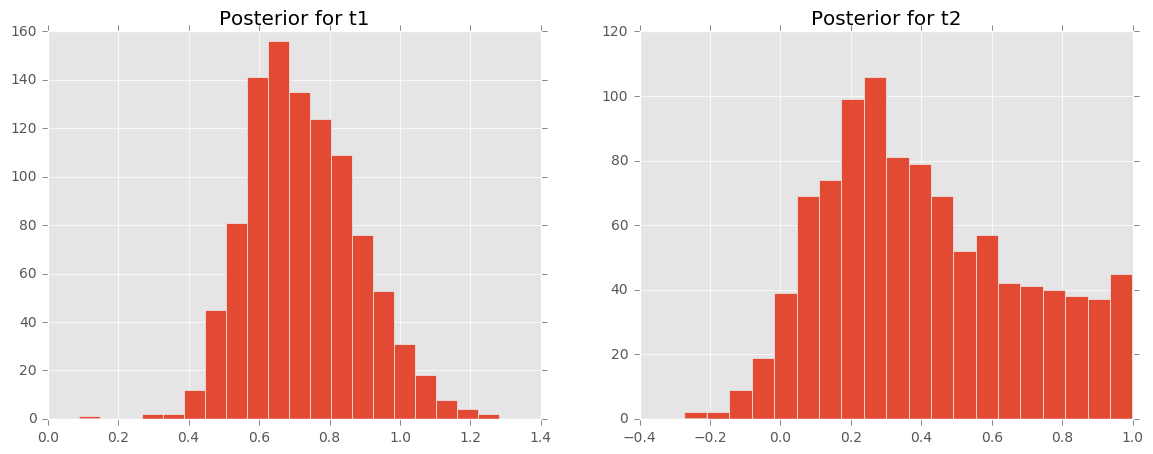

In [16]:
fig, ax = plt.subplots(ncols=2, figsize=(14,5));
ax[0].hist(t1_post, bins=20);
ax[0].set_title("Posterior for t1");
ax[1].hist(t2_post, bins=20);
ax[1].set_title("Posterior for t2");

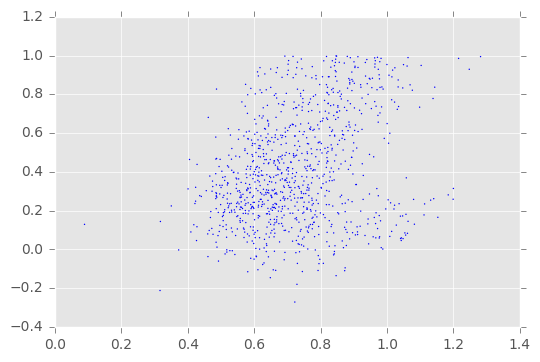

In [17]:
# A 2D visualization may be more appropriate
plt.scatter(t1_post, t2_post, s=1, edgecolor='none');

<a id='parallelization'></a>


### Automatic parallelization

Behind the scenes, ELFI uses the [Dask](http://dask.pydata.org/) library to automatically parallelize (most of) the computational inference. The parallelization can be tuned with the keyword argument `batch_size` for the Rejection class, which tells how many "runs"$^1$ should be sent to each available computational unit at a time. There is some overhead involved in the parallelization, so batches should be large, but not too large to eat all your memory.

$^1$To be more accurate, the MA2 model as well as the other functions in this example are vectorized, and the simulator is actually called just a few times with the keyword argument `n_sim` set to `batch_size`. This results in more efficient usage of numpy operations. Whenever possible, functions should be written in a form that allows vectorization.

The underlying Dask graph for our inference can be visualized (partly):

In [18]:
from dask.dot import dot_graph
# dot_graph(d[0:4].dask)

### Sequential Monte Carlo ABC

Rejection sampling is quite inefficient, as it does not learn from its history. The sequential Monte Carlo (SMC) ABC algorithm does just that by applying importance sampling: samples are *weighed* according to the resulting discrepancies and the next *population* of samples is drawn near to the previous using the weights as probabilities. 

For evaluating the weights, SMC ABC needs to have probability density functions for the priors. In our MA2 example the second prior is conditional on the first, which complicates matters a bit. Let's modify the prior distribution classes:

In [19]:
# define prior for t1 as in Marin et al., 2012 with t1 in range [-b, b]
class MarinPrior_t1():
    def rvs(b, size=1, random_state=None):
        u = scipy.stats.uniform.rvs(loc=0, scale=1, size=size, random_state=random_state)
        t1 = np.where(u<0.5, np.sqrt(2.*u)*b-b, -np.sqrt(2.*(1.-u))*b+b)
        return t1
    
    def pdf(t1, b):
        p = 1./b - np.abs(t1) / (b*b)
        p = np.where(p < 0., 0., p)  # disallow values outside of [-b, b] (affects weights only)
        return p

# define prior for t2 conditionally on t1 as in Marin et al., 2012, in range [-a, a]
class MarinPrior_t2():
    def rvs(t1, a, size=1, random_state=None):
        locs = np.maximum(-a-t1, t1-a)
        scales = a - locs 
        t2 = scipy.stats.uniform.rvs(loc=locs, scale=scales, size=size, random_state=random_state)
        return t2
    
    def pdf(t2, _, a, with_values):
        t1 = with_values['t1']
        locs = np.maximum(-a-t1, t1-a)
        scales = a - locs
        p = scipy.stats.uniform.pdf(t2, loc=locs, scale=scales)
        p = np.where(scales>0., p, 0.)  # disallow values outside of [-a, a] (affects weights only)
        return p

    
# define new priors
t1m = elfi.Prior('t1', MarinPrior_t1, 2)
t2m = elfi.Prior('t2', MarinPrior_t2, t1, 1)

# change these in place of the earlier nodes, keeping the old children
t1 = t1.change_to(t1m, transfer_parents=False, transfer_children=True)
t2 = t2.change_to(t2m, transfer_parents=False, transfer_children=True)

elfi.graph - WARNING - Node with name t1 exists. Renaming old to t1_old.
elfi.graph - WARNING - Node with name t2 exists. Renaming old to t2_old.


In ELFI, one can setup a SMC ABC sampler just like the Rejection sampler:

In [20]:
smc = elfi.SMC(d, [t1, t2], batch_size=10000)

For sampling, one has to define the number of output samples, the number of populations and a *schedule* i.e. a list of quantiles to use for each population. In essence, a population is just refined rejection sampling.

In [21]:
N = 1000
n_populations = 3
schedule = [0.1, 0.1, 0.1]
%time result_dict = smc.sample(N, n_populations, schedule)

elfi.methods - INFO - SMC: Running with 10000 proposals.
elfi.methods - DEBUG - SMC: Need 10000 new proposals.
elfi.methods - DEBUG - SMC: Need 3693 new proposals.
elfi.methods - DEBUG - SMC: Need 1364 new proposals.
elfi.methods - DEBUG - SMC: Need 464 new proposals.
elfi.methods - DEBUG - SMC: Need 162 new proposals.
elfi.methods - DEBUG - SMC: Need 69 new proposals.
elfi.methods - DEBUG - SMC: Need 27 new proposals.
elfi.methods - DEBUG - SMC: Need 8 new proposals.
elfi.methods - DEBUG - SMC: Need 2 new proposals.
elfi.methods - INFO - SMC: Running with 10000 proposals.
elfi.methods - DEBUG - SMC: Need 10000 new proposals.
elfi.methods - DEBUG - SMC: Need 4392 new proposals.
elfi.methods - DEBUG - SMC: Need 1892 new proposals.
elfi.methods - DEBUG - SMC: Need 846 new proposals.
elfi.methods - DEBUG - SMC: Need 330 new proposals.
elfi.methods - DEBUG - SMC: Need 135 new proposals.
elfi.methods - DEBUG - SMC: Need 58 new proposals.
elfi.methods - DEBUG - SMC: Need 21 new proposals.
el

CPU times: user 789 ms, sys: 249 ms, total: 1.04 s
Wall time: 1.02 s


Let's see what we got:

Posterior means for population 1: t1: 0.97 t2: 0.52
Posterior means for population 2: t1: 0.96 t2: 0.49
Posterior means for population 3: t1: 0.93 t2: 0.50


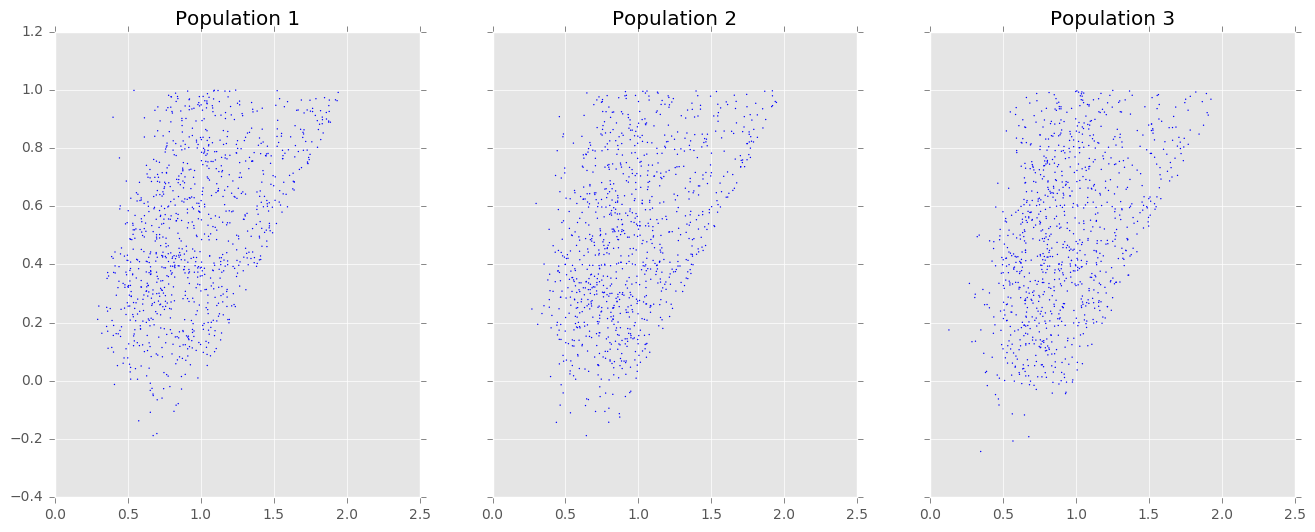

In [22]:
fig, ax = plt.subplots(ncols=n_populations, sharex=True, sharey=True, figsize=(16,6))
for ii in range(n_populations-1):
    data = result_dict['samples_history'][ii]
    print("Posterior means for population {}: t1: {:.2f} t2: {:.2f}".format(ii+1, data[0].mean(), data[1].mean()))
    ax[ii].scatter(data[0], data[1], s=1, edgecolor='none');
    ax[ii].set_title("Population {}".format(ii+1));
data = result_dict['samples']
print("Posterior means for population {}: t1: {:.2f} t2: {:.2f}".format(n_populations, data[0].mean(), data[1].mean()))
ax[n_populations-1].scatter(data[0], data[1], s=1, edgecolor='none');
ax[n_populations-1].set_title("Population {}".format(n_populations));

It can be seen that the populations iteratively concentrate more and more around the true parameter values.

Note that for the later populations some of the samples lie outside allowed region. This is due to the SMC algorithm sampling near previous samples, with *near* meaning a Gaussian distribution centered around previous samples with variance as twice the weighted empirical variance. However, the outliers carry zero weight, as was defined in the prior pdfs.

### Bayesian Optimization for Likelihood-Free Inference (BOLFI)

In practice inference problems often have a more complicated and computationally heavy simulator than the function `MA2` here, and one simply cannot run it for millions of times. The [BOLFI](https://arxiv.org/abs/1501.03291) framework is likely to prove useful in such situation: a statistical model (e.g. [Gaussian process](https://en.wikipedia.org/wiki/Gaussian_process)) is created for the discrepancy, and its minimum is inferred with [Bayesian optimization](https://en.wikipedia.org/wiki/Bayesian_optimization). This approach typically reduces the number of required simulator calls by several orders of magnitude.

As BOLFI is more advanced inference method, its interface is also a bit more involved. But not much: Using the same graphical model as earlier, the inference begins by defining a Gaussian process model, for which we use the [GPy](https://sheffieldml.github.io/GPy/) library. We are inferring 2 parameters with the same bounds as earlier, and we have to give these conditions to the surrogate model i.e. the Gaussian process.

In [23]:
gp_model = elfi.GPyModel(input_dim=2, bounds=((-2,2), (-1,1)))

Having defined the surrogate model, we can instantiate the BOLFI framework object in a somewhat similar way as earlier, except that we now additionally define the surrogate model and the number of samples to take from it (this is the number of simulator calls): 

In [24]:
bolfi = elfi.BOLFI(d, [t1, t2], batch_size=20, n_surrogate_samples=150, model=gp_model)

elfi.methods - DEBUG - BOLFI: No dask client given, creating a local client.


The BOLFI class can now try to `infer` the posterior distribution of the parameters:

In [25]:
post = bolfi.infer()

elfi.methods - INFO - BOLFI: Sampling 150 samples in batches of 20
elfi.methods - DEBUG - BOLFI: Observed 0.217202 at [ 1.29614738  0.43446617].
elfi.methods - DEBUG - BOLFI: Observed 0.883619 at [-1.89358494 -0.61843879].
elfi.methods - DEBUG - BOLFI: Observed 0.716916 at [-1.8126937  -0.73699977].
elfi.methods - DEBUG - BOLFI: Observed 0.859937 at [-1.87850931 -0.46967691].
elfi.methods - DEBUG - BOLFI: Observed 0.855403 at [-1.41248894 -0.32133088].
elfi.methods - DEBUG - BOLFI: Observed 0.807728 at [ 0.19865263 -0.58556253].
elfi.methods - DEBUG - BOLFI: Observed 0.973073 at [-0.63150032  0.04084047].
elfi.methods - DEBUG - BOLFI: Observed 0.740077 at [ 0.75512973 -0.64762991].
elfi.methods - DEBUG - BOLFI: Observed 0.962582 at [-0.63014795 -0.62066888].
elfi.methods - DEBUG - BOLFI: Observed 0.873088 at [-0.17070379 -0.51017351].
elfi.methods - DEBUG - BOLFI: Observed 0.051044 at [ 1.3786203  -0.19619077].
elfi.methods - DEBUG - BOLFI: Observed 0.170490 at [ 0.1828633   0.14416469

We can get estimates for *maximum a posteriori* and *maximum likelihood* easily:

In [26]:
post.MAP, post.ML

(array([ 1.105111  , -0.05004273]), array([ 1.10491807, -0.05017385]))

We can also plot the Gaussian process using GPy:

 /Users/vuolleh2/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


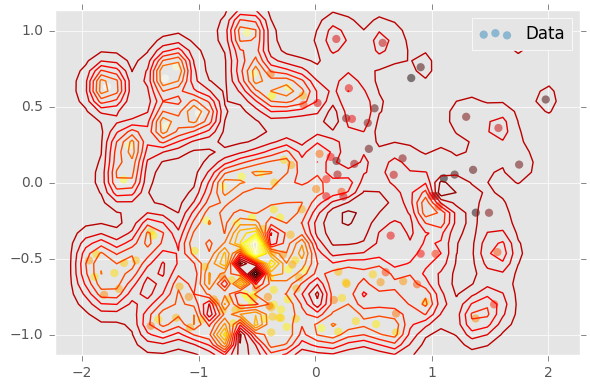

In [27]:
bolfi.model.gp.plot();

... or we can visualize the posterior directly:

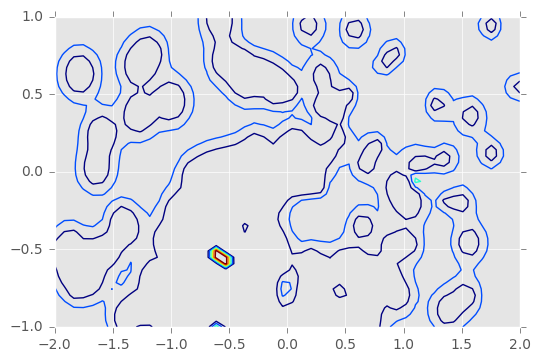

In [28]:
x, y = np.meshgrid(np.linspace(-2, 2), np.linspace(-1, 1))
z = np.empty_like(x)
for ii in range(len(x)):
    for jj in range(len(x)):
        z[ii, jj] = post.pdf(np.array([x[ii, jj], y[ii, jj]]))
plt.contour(x, y, z);

### Saving samples for later use

Saving performed computations is often a good idea, especially if the simulator is expensive to call. ELFI supports persistence of results in multiple formats. The user simply has to define this with the `store` keyword argument, which can be given to all nodes in the graphical model upon instantiation.

To cache the prior `t1` in memory (affects only `t1`):

In [29]:
t1 = elfi.Prior('t1', 'uniform', 0, 1, store="cache")

elfi.graph - WARNING - Node with name t1 exists. Renaming old to t1_old_old.


To store directly in a Numpy array, which can afterwards be processed using any Numpy compatible library:

In [30]:
max_samples = 10000000
t1_array = np.empty((max_samples, 1))  # make sure you allocate enough memory
t1_arr = elfi.Prior('t1_arr', 'uniform', 0, 1, store=t1_array)

# Save in binary Numpy format:
# np.save('t1.npy', t1_array)

# Save in ascii csv format:
# np.savetxt('t1.csv', t1_array, delimiter=', ')

# Save in HDF5 format:
# import h5py
# h5file = h5py.File('ma2.hdf', 'w')
# h5file.create_dataset('t1', data=t1_array)
# h5file.close()

Numpy arrays can also be used indirectly via a `LocalDataStore` object:

**...... Is there some benefit from using this?**

In [31]:
object_store = elfi.LocalDataStore(t1_array)
t1 = elfi.Prior('t1', 'uniform', 0, 1, store=object_store)

elfi.graph - WARNING - Node with name t1 exists. Renaming old to t1_old_old_old.


A NoSQL database is also supported, in which case the results are saved to collection matching node name:

In [32]:
nosql_store = elfi.UnQLiteStore()  # accepts filename to save to disk
Y = elfi.Simulator('MA2', MA2, t1, t2, observed=y, store=nosql_store)

# afterwards get data:
# Y_array = nosql_store.get('Y', slice(0,1000))

elfi.graph - WARNING - Node with name MA2 exists. Renaming old to MA2_old.
